In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Simplified Flip-Flop RNN for Reuse/Overwrite Study
Observing: Fixed points, W_rec structure, network dynamics
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


class SimpleFlipFlopTask:
    """
    Simplified flip-flop: single channel (easier to visualize)
    Input: pulses of +1 or -1
    Output: maintain last input value
    """
    def __init__(self, batch_size=32, seq_len=200):
        self.batch_size = batch_size
        self.seq_len = seq_len
        
    def generate(self, flip_prob=0.03):
        """
        Generate flip-flop data
        Returns:
            inputs: (batch, time, 1) - sparse pulses
            targets: (batch, time, 1) - memory state
        """
        inputs = torch.zeros(self.batch_size, self.seq_len, 1)
        targets = torch.zeros(self.batch_size, self.seq_len, 1)
        
        for b in range(self.batch_size):
            # Initial state
            state = np.random.choice([-1, 1])
            targets[b, 0, 0] = state
            inputs[b, 0, 0] = state
            
            for t in range(1, self.seq_len):
                # Random flip with probability
                if np.random.rand() < flip_prob:
                    state = np.random.choice([-1, 1])
                    inputs[b, t, 0] = state
                
                targets[b, t, 0] = state
        
        return inputs, targets


class SimpleRNN(nn.Module):
    """
    Vanilla RNN: h(t+1) = tanh(W_rec @ h(t) + W_in @ u(t) + b)
    Simple enough to analyze fixed points and dynamics
    """
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(SimpleRNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        # Initialize with small random weights
        self.W_rec = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.5 / np.sqrt(hidden_size))
        self.W_in = nn.Parameter(torch.randn(hidden_size, input_size) * 1.0)
        self.W_out = nn.Parameter(torch.randn(output_size, hidden_size) * 1.0)
        self.b_rec = nn.Parameter(torch.zeros(hidden_size))
        self.b_out = nn.Parameter(torch.zeros(output_size))
        
    def forward(self, inputs, return_states=False):
        """
        Args:
            inputs: (batch, time, input_size)
            return_states: if True, return all hidden states
        Returns:
            outputs: (batch, time, output_size)
            states: (batch, time, hidden_size) if return_states=True
        """
        batch_size, seq_len, _ = inputs.shape
        
        # Initialize hidden state
        h = torch.zeros(batch_size, self.hidden_size)
        
        outputs = []
        states = [h] if return_states else None
        
        for t in range(seq_len):
            u = inputs[:, t, :]
            
            # RNN update: h = tanh(W_rec @ h + W_in @ u + b)
            h = torch.tanh(h @ self.W_rec.t() + u @ self.W_in.t() + self.b_rec)
            
            # Output
            o = h @ self.W_out.t() + self.b_out
            outputs.append(o)
            
            if return_states:
                states.append(h)
        
        outputs = torch.stack(outputs, dim=1)
        
        if return_states:
            states = torch.stack(states, dim=1)  # (batch, time+1, hidden)
            return outputs, states
        
        return outputs


def train_rnn(model, task, n_epochs=500, lr=0.01, verbose=True):
    """Train the RNN on flip-flop task"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    losses = []
    
    if verbose:
        print("=" * 60)
        print("Training RNN on Flip-Flop Task")
        print("=" * 60)
    
    for epoch in range(n_epochs):
        # Generate fresh batch each epoch
        inputs, targets = task.generate()
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Loss
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if verbose and (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1:4d}/{n_epochs} | Loss: {loss.item():.6f}")
    
    if verbose:
        print("=" * 60)
        print("Training Complete!")
        print("=" * 60)
    
    return losses


def find_fixed_points(model, input_val=0.0, n_inits=50, lr=0.1, max_iter=1000, tol=1e-6):
    """
    Find fixed points of the RNN dynamics for a given input
    
    Fixed point satisfies: h* = tanh(W_rec @ h* + W_in @ u + b)
    
    Args:
        model: trained RNN
        input_val: constant input value
        n_inits: number of random initializations
        lr: learning rate for fixed point finding
        max_iter: maximum iterations
        tol: convergence tolerance
    
    Returns:
        unique_fps: list of unique fixed points
        stabilities: list of stability indicators (max eigenvalue magnitude)
    """
    W_rec = model.W_rec.detach()
    W_in = model.W_in.detach()
    b_rec = model.b_rec.detach()
    
    u = torch.tensor([[input_val]])
    
    fixed_points = []
    
    for init in range(n_inits):
        # Random initialization - make it a LEAF tensor
        h_init = torch.randn(1, model.hidden_size) * 0.5
        h = h_init.clone().detach().requires_grad_(True)  # FIX: Make it a proper leaf
        
        optimizer = torch.optim.Adam([h], lr=lr)
        
        for iteration in range(max_iter):
            optimizer.zero_grad()
            
            # Fixed point condition: h_next should equal h
            h_next = torch.tanh(h @ W_rec.t() + u @ W_in.t() + b_rec)
            
            # Minimize distance between h and h_next
            loss = torch.sum((h_next - h) ** 2)
            
            loss.backward()
            optimizer.step()
            
            if loss.item() < tol:
                break
        
        # Check if converged
        if loss.item() < tol:
            fixed_points.append(h.detach().clone())
    
    # Remove duplicates
    unique_fps = []
    for fp in fixed_points:
        is_duplicate = False
        for ufp in unique_fps:
            if torch.norm(fp - ufp) < 0.1:
                is_duplicate = True
                break
        if not is_duplicate:
            unique_fps.append(fp)
    
    # Compute stability (eigenvalues of Jacobian)
    stabilities = []
    for fp in unique_fps:
        # Jacobian: J = W_rec * diag(1 - tanh²(W_rec @ h* + ...))
        h_star = fp.squeeze()
        activation = h_star @ W_rec.t() + u @ W_in.t() + b_rec
        diag_derivative = 1 - torch.tanh(activation) ** 2
        
        # J = W_rec * D where D is diagonal (element-wise multiply each row)
        J = W_rec * diag_derivative.unsqueeze(0)  # Broadcasting
        
        eigenvalues = torch.linalg.eigvals(J)
        max_eig = torch.max(torch.abs(eigenvalues)).item()
        stabilities.append(max_eig)
    
    return unique_fps, stabilities


def visualize_training(losses, model, task):
    """
    Visualize training results
    """
    fig = plt.figure(figsize=(16, 10))
    
    # 1. Loss curve
    ax1 = plt.subplot(3, 3, 1)
    ax1.plot(losses, linewidth=2, color='#2E86AB')
    ax1.set_xlabel('Epoch', fontsize=11)
    ax1.set_ylabel('Loss (MSE)', fontsize=11)
    ax1.set_title('Training Loss', fontsize=12, fontweight='bold')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)
    
    # 2. Example trial
    task.batch_size = 1
    inputs, targets = task.generate(flip_prob=0.05)
    
    with torch.no_grad():
        outputs, states = model(inputs, return_states=True)
    
    time = np.arange(task.seq_len)
    
    # Input
    ax2 = plt.subplot(3, 3, 2)
    inp = inputs[0, :, 0].numpy()
    flip_times = time[inp != 0]
    flip_vals = inp[inp != 0]
    ax2.stem(flip_times, flip_vals, linefmt='C0-', markerfmt='C0o', basefmt='k-')
    ax2.set_ylabel('Input', fontsize=11)
    ax2.set_title('Input Pulses', fontsize=12, fontweight='bold')
    ax2.set_ylim([-1.5, 1.5])
    ax2.grid(True, alpha=0.3)
    
    # Output vs Target
    ax3 = plt.subplot(3, 3, 3)
    ax3.plot(time, targets[0, :, 0].numpy(), 'k-', linewidth=3, 
             label='Target', alpha=0.6)
    ax3.plot(time, outputs[0, :, 0].numpy(), 'C3--', linewidth=2, 
             label='Predicted')
    ax3.set_ylabel('Output', fontsize=11)
    ax3.set_title('Network Output', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.set_ylim([-1.5, 1.5])
    ax3.grid(True, alpha=0.3)
    
    # 3. Hidden state activity (first 10 units)
    ax4 = plt.subplot(3, 3, 4)
    for i in range(min(10, model.hidden_size)):
        ax4.plot(time, states[0, 1:, i].numpy(), alpha=0.6, linewidth=1)
    ax4.set_xlabel('Time', fontsize=11)
    ax4.set_ylabel('Hidden State', fontsize=11)
    ax4.set_title('Sample Hidden Units (10 units)', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # 4. W_rec heatmap
    ax5 = plt.subplot(3, 3, 5)
    W_rec_np = model.W_rec.detach().numpy()
    im = ax5.imshow(W_rec_np, cmap='RdBu_r', aspect='auto', 
                    vmin=-np.max(np.abs(W_rec_np)), vmax=np.max(np.abs(W_rec_np)))
    ax5.set_title('Recurrent Weights (W_rec)', fontsize=12, fontweight='bold')
    ax5.set_xlabel('From Unit', fontsize=10)
    ax5.set_ylabel('To Unit', fontsize=10)
    plt.colorbar(im, ax=ax5, fraction=0.046)
    
    # 5. W_rec eigenvalue spectrum
    ax6 = plt.subplot(3, 3, 6)
    eigenvalues = torch.linalg.eigvals(model.W_rec.detach())
    eig_real = eigenvalues.real.numpy()
    eig_imag = eigenvalues.imag.numpy()
    ax6.scatter(eig_real, eig_imag, alpha=0.6, s=30)
    circle = plt.Circle((0, 0), 1, fill=False, color='red', 
                        linestyle='--', label='Unit circle')
    ax6.add_patch(circle)
    ax6.set_xlabel('Real', fontsize=11)
    ax6.set_ylabel('Imaginary', fontsize=11)
    ax6.set_title('W_rec Eigenvalues', fontsize=12, fontweight='bold')
    ax6.axhline(0, color='k', linewidth=0.5)
    ax6.axvline(0, color='k', linewidth=0.5)
    ax6.legend()
    ax6.set_aspect('equal')
    ax6.grid(True, alpha=0.3)
    
    # 6. Full state space trajectory (2D PCA)
    ax7 = plt.subplot(3, 3, 7)
    states_np = states[0].numpy()
    
    # PCA to 2D
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    states_2d = pca.fit_transform(states_np)
    
    # Color by time
    scatter = ax7.scatter(states_2d[:, 0], states_2d[:, 1], 
                          c=np.arange(len(states_2d)), 
                          cmap='viridis', s=10, alpha=0.6)
    ax7.plot(states_2d[0, 0], states_2d[0, 1], 'go', 
             markersize=10, label='Start')
    ax7.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10)
    ax7.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10)
    ax7.set_title('State Space Trajectory (PCA)', fontsize=12, fontweight='bold')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax7, label='Time', fraction=0.046)
    
    # 7. Find and plot fixed points
    print("\nFinding fixed points...")
    fps, stabs = find_fixed_points(model, input_val=0.0, n_inits=100)
    
    ax8 = plt.subplot(3, 3, 8)
    print(f"Found {len(fps)} unique fixed points")
    
    if len(fps) > 0:
        # Project fixed points to same PCA space
        fps_np = torch.stack([fp.squeeze() for fp in fps]).numpy()
        fps_2d = pca.transform(fps_np)
        
        # Color by stability
        colors = ['red' if s > 1 else 'green' for s in stabs]
        for i, (fp_2d, stab) in enumerate(zip(fps_2d, stabs)):
            ax8.plot(fp_2d[0], fp_2d[1], 'o', color=colors[i], 
                    markersize=15, alpha=0.8,
                    label=f'FP{i+1} (λ={stab:.2f})')
            
        # Also plot trajectory
        ax8.plot(states_2d[:, 0], states_2d[:, 1], 'b-', alpha=0.2, linewidth=1)
        
        ax8.set_xlabel('PC1', fontsize=10)
        ax8.set_ylabel('PC2', fontsize=10)
        ax8.set_title('Fixed Points in State Space', fontsize=12, fontweight='bold')
        ax8.legend(fontsize=8, loc='best')
        ax8.grid(True, alpha=0.3)
        
        # Print fixed point info
        print("\nFixed Point Analysis:")
        for i, (fp, stab) in enumerate(zip(fps, stabs)):
            stability_str = "STABLE" if stab < 1 else "UNSTABLE"
            print(f"  FP {i+1}: max|λ| = {stab:.3f} ({stability_str})")
    
    # 8. State space variance (which dimensions are used?)
    ax9 = plt.subplot(3, 3, 9)
    state_var = torch.var(states[0], dim=0).numpy()
    ax9.bar(range(len(state_var)), np.sort(state_var)[::-1], color='C2', alpha=0.7)
    ax9.set_xlabel('Unit (sorted)', fontsize=10)
    ax9.set_ylabel('Variance', fontsize=10)
    ax9.set_title('Hidden State Variance per Unit', fontsize=12, fontweight='bold')
    ax9.set_yscale('log')
    ax9.grid(True, alpha=0.3, axis='y')
    
    # Add text with key metrics
    active_dims = (state_var > 0.01 * np.max(state_var)).sum()
    ax9.text(0.6, 0.9, f'Active dims (~1% thresh): {active_dims}', 
             transform=ax9.transAxes, fontsize=9,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle('RNN Training Results - Flip-Flop Task', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()
    
    return fig, fps, stabs


def main():
    """Main execution"""
    print("\n" + "="*60)
    print("FLIP-FLOP RNN - BASELINE TRAINING")
    print("="*60 + "\n")
    
    # Create task
    task = SimpleFlipFlopTask(batch_size=32, seq_len=200)
    
    # Create model
    model = SimpleRNN(input_size=1, hidden_size=50, output_size=1)
    
    # Train
    losses = train_rnn(model, task, n_epochs=500, lr=0.01, verbose=True)
    
    # Visualize
    fig, fps, stabs = visualize_training(losses, model, task)
    
    # Test performance
    print("\n" + "="*60)
    print("FINAL PERFORMANCE")
    print("="*60)
    task.batch_size = 100
    inputs, targets = task.generate()
    with torch.no_grad():
        outputs = model(inputs)
    
    mse = nn.MSELoss()(outputs, targets).item()
    accuracy = (torch.abs(outputs - targets) < 0.1).float().mean().item()
    
    print(f"Test MSE:      {mse:.6f}")
    print(f"Accuracy:      {accuracy*100:.2f}%")
    print(f"Fixed Points:  {len(fps)}")
    print("="*60 + "\n")
    
    # Save model for future experiments
    torch.save({
        'model_state_dict': model.state_dict(),
        'losses': losses,
        'fixed_points': fps,
        'stabilities': stabs
    }, 'flipflop_baseline.pt')
    
    print("Model saved to 'flipflop_baseline.pt'")
    print("Ready for reinitialization and reshuffling experiments!\n")
    
    return model, losses, fps, stabs




FLIP-FLOP RNN - BASELINE TRAINING

Training RNN on Flip-Flop Task
Epoch  100/500 | Loss: 0.039577
Epoch  200/500 | Loss: 0.002204
Epoch  300/500 | Loss: 0.000497
Epoch  400/500 | Loss: 0.000559
Epoch  500/500 | Loss: 0.000110
Training Complete!

Finding fixed points...
Found 3 unique fixed points

Fixed Point Analysis:
  FP 1: max|λ| = 1.338 (UNSTABLE)
  FP 2: max|λ| = 0.546 (STABLE)
  FP 3: max|λ| = 0.538 (STABLE)


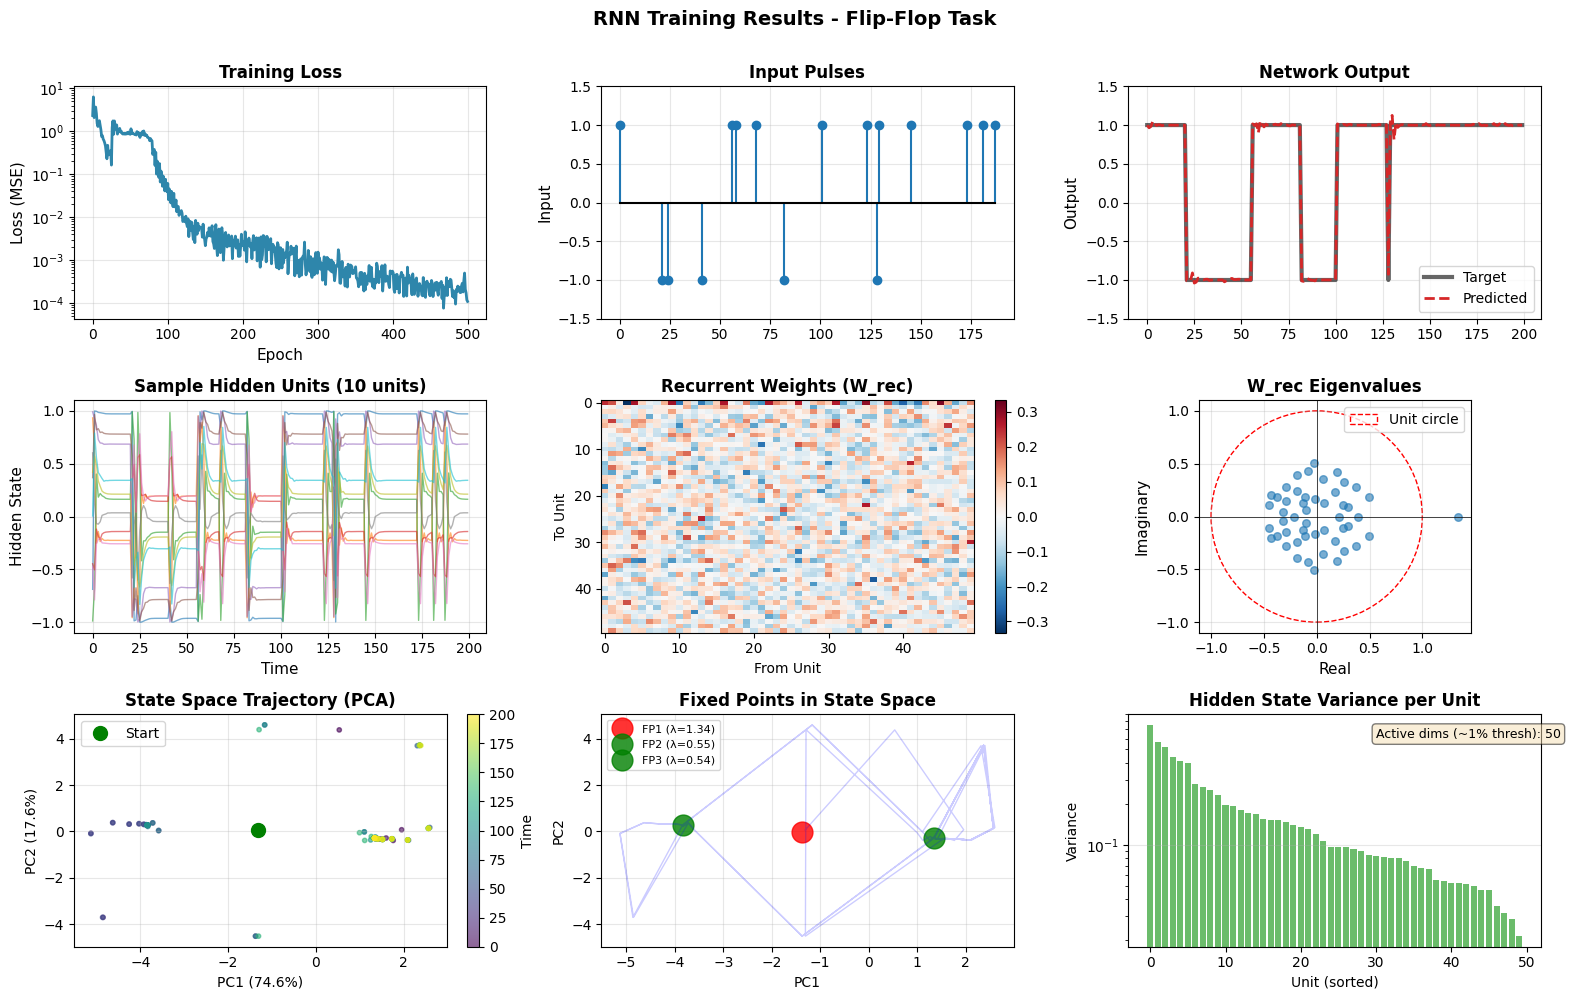


FINAL PERFORMANCE
Test MSE:      0.000239
Accuracy:      99.55%
Fixed Points:  3

Model saved to 'flipflop_baseline.pt'
Ready for reinitialization and reshuffling experiments!



In [ ]:
if __name__ == "__main__":
    model, losses, fps, stabs = main()

In [2]:
# ==============================================================================
# GPU-ACCELERATED REINITIALIZATION EXPERIMENT
# Add this to your existing notebook
# ==============================================================================

import pickle

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🚀 Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}\n")


def reinitialization_experiment(n_runs=20, hidden_size=50, n_epochs=500, save_results=True):
    """
    Train flip-flop multiple times with different random seeds
    Track: fixed points, W_rec, performance
    """
    
    print("\n" + "="*70)
    print(f"REINITIALIZATION EXPERIMENT: {n_runs} RUNS ON {device}")
    print("="*70 + "\n")
    
    results = {
        'models': [],
        'losses': [],
        'fixed_points': [],
        'stabilities': [],
        'W_rec_matrices': [],
        'W_rec_eigenvalues': [],
        'final_mse': [],
        'n_fixed_points': [],
        'seeds': []
    }
    
    for run in range(n_runs):
        seed = run * 42
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        print(f"Run {run+1}/{n_runs} (seed={seed})...", end=" ")
        
        # Create task and model on GPU
        task = SimpleFlipFlopTask(batch_size=32, seq_len=200)
        model = SimpleRNN(input_size=1, hidden_size=hidden_size, output_size=1).to(device)
        
        # Move task data to GPU during training
        original_generate = task.generate
        def generate_gpu(flip_prob=0.03):
            inputs, targets = original_generate(flip_prob)
            return inputs.to(device), targets.to(device)
        task.generate = generate_gpu
        
        # Train on GPU
        losses = train_rnn(model, task, n_epochs=n_epochs, lr=0.01, verbose=False)
        
        # Find fixed points on GPU
        fps, stabs = find_fixed_points(model, input_val=0.0, n_inits=100)
        
        # Evaluate on GPU
        task.batch_size = 100
        inputs, targets = task.generate()
        with torch.no_grad():
            outputs = model(inputs)
        mse = nn.MSELoss()(outputs, targets).item()
        
        # Move results to CPU for storage
        W_rec = model.W_rec.detach().cpu()
        eigenvalues = torch.linalg.eigvals(W_rec)
        
        results['models'].append({k: v.cpu() for k, v in model.state_dict().items()})
        results['losses'].append(losses)
        results['fixed_points'].append([fp.cpu() for fp in fps])
        results['stabilities'].append(stabs)
        results['W_rec_matrices'].append(W_rec.numpy())
        results['W_rec_eigenvalues'].append(eigenvalues.numpy())
        results['final_mse'].append(mse)
        results['n_fixed_points'].append(len(fps))
        results['seeds'].append(seed)
        
        # Quick summary
        stable = sum(1 for s in stabs if s < 1)
        print(f"Loss: {losses[-1]:.6f}, FPs: {len(fps)} ({stable} stable)")
        
        # Clear GPU memory
        if device.type == 'cuda':
            torch.cuda.empty_cache()
    
    print("\n" + "="*70)
    print("✅ All runs complete!")
    print("="*70 + "\n")
    
    if save_results:
        with open('reinitialization_results.pkl', 'wb') as f:
            pickle.dump(results, f)
        print("💾 Results saved to 'reinitialization_results.pkl'\n")
    
    return results


def analyze_reinitialization_results(results):
    """Visualize and analyze reinitialization results"""
    n_runs = len(results['models'])
    
    fig = plt.figure(figsize=(18, 12))
    
    # 1. Fixed point count distribution
    ax1 = plt.subplot(3, 4, 1)
    n_fps = results['n_fixed_points']
    counts = {n: n_fps.count(n) for n in set(n_fps)}
    ax1.bar(counts.keys(), counts.values(), color='skyblue', edgecolor='black', linewidth=1.5)
    ax1.set_xlabel('Number of Fixed Points', fontsize=11)
    ax1.set_ylabel('Frequency', fontsize=11)
    ax1.set_title(f'FP Count Distribution\n(Mode: {max(counts, key=counts.get)} FPs)', 
                  fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 2. Stability distribution
    ax2 = plt.subplot(3, 4, 2)
    all_stabs = [s for stabs in results['stabilities'] for s in stabs]
    ax2.hist(all_stabs, bins=30, color='coral', alpha=0.7, edgecolor='black')
    ax2.axvline(1.0, color='red', linestyle='--', linewidth=2, label='Stability threshold')
    ax2.set_xlabel('Max |λ|', fontsize=11)
    ax2.set_ylabel('Count', fontsize=11)
    ax2.set_title('FP Stability Distribution', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Performance across runs
    ax3 = plt.subplot(3, 4, 3)
    ax3.plot(results['final_mse'], 'o-', color='green', markersize=6)
    ax3.axhline(np.mean(results['final_mse']), color='red', linestyle='--', 
                label=f'Mean: {np.mean(results["final_mse"]):.6f}')
    ax3.set_xlabel('Run', fontsize=11)
    ax3.set_ylabel('Final MSE', fontsize=11)
    ax3.set_title('Performance Consistency', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)
    
    # 4. Stable vs unstable FPs
    ax4 = plt.subplot(3, 4, 4)
    stable_counts = [sum(1 for s in stabs if s < 1) for stabs in results['stabilities']]
    unstable_counts = [sum(1 for s in stabs if s >= 1) for stabs in results['stabilities']]
    
    x = np.arange(n_runs)
    ax4.bar(x, stable_counts, label='Stable (λ<1)', color='green', alpha=0.7)
    ax4.bar(x, unstable_counts, bottom=stable_counts, label='Unstable (λ≥1)', 
            color='red', alpha=0.7)
    ax4.set_xlabel('Run', fontsize=11)
    ax4.set_ylabel('Count', fontsize=11)
    ax4.set_title('Stable vs Unstable FPs', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    # 5. Spectral radius
    ax5 = plt.subplot(3, 4, 5)
    spectral_radii = [np.max(np.abs(eigs)) for eigs in results['W_rec_eigenvalues']]
    ax5.plot(spectral_radii, 'o-', color='purple', markersize=6)
    ax5.axhline(1.0, color='red', linestyle='--', linewidth=2)
    ax5.set_xlabel('Run', fontsize=11)
    ax5.set_ylabel('Spectral Radius', fontsize=11)
    ax5.set_title('W_rec Spectral Radius', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3)
    
    # 6. W_rec norm
    ax6 = plt.subplot(3, 4, 6)
    W_norms = [np.linalg.norm(W, 'fro') for W in results['W_rec_matrices']]
    ax6.plot(W_norms, 'o-', color='brown', markersize=6)
    ax6.axhline(np.mean(W_norms), color='red', linestyle='--')
    ax6.set_xlabel('Run', fontsize=11)
    ax6.set_ylabel('||W_rec||_F', fontsize=11)
    ax6.set_title('W_rec Frobenius Norm', fontsize=12, fontweight='bold')
    ax6.grid(True, alpha=0.3)
    
    # 7. All fixed points in PCA space
    ax7 = plt.subplot(3, 4, 7)
    all_fps = []
    run_labels = []
    for run_idx, fps in enumerate(results['fixed_points']):
        for fp in fps:
            all_fps.append(fp.squeeze().numpy())
            run_labels.append(run_idx)
    
    if len(all_fps) > 0:
        all_fps = np.array(all_fps)
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        fps_2d = pca.fit_transform(all_fps)
        
        scatter = ax7.scatter(fps_2d[:, 0], fps_2d[:, 1], 
                             c=run_labels, cmap='tab20', 
                             s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
        ax7.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
        ax7.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
        ax7.set_title('All Fixed Points (PCA)', fontsize=12, fontweight='bold')
        ax7.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax7, label='Run')
    
    # 8. Learning curves
    ax8 = plt.subplot(3, 4, 8)
    for i in range(min(10, n_runs)):
        ax8.plot(results['losses'][i], alpha=0.5, linewidth=1)
    ax8.set_xlabel('Epoch', fontsize=11)
    ax8.set_ylabel('Loss', fontsize=11)
    ax8.set_title('Learning Curves', fontsize=12, fontweight='bold')
    ax8.set_yscale('log')
    ax8.grid(True, alpha=0.3)
    
    # 9-12. W_rec examples
    for i, run_idx in enumerate([0, n_runs//3, 2*n_runs//3, n_runs-1]):
        ax = plt.subplot(3, 4, 9 + i)
        W = results['W_rec_matrices'][run_idx]
        im = ax.imshow(W, cmap='RdBu_r', aspect='auto',
                      vmin=-np.max(np.abs(W)), vmax=np.max(np.abs(W)))
        ax.set_title(f'W_rec Run {run_idx+1}', fontsize=10, fontweight='bold')
        plt.colorbar(im, ax=ax, fraction=0.046)
    
    plt.suptitle(f'Reinitialization: {n_runs} Independent Runs', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()
    
    # Print statistics
    print("\n" + "="*70)
    print("📊 SUMMARY STATISTICS")
    print("="*70)
    print(f"Runs: {n_runs}\n")
    print(f"Fixed Points:")
    print(f"  Mean: {np.mean(n_fps):.2f} ± {np.std(n_fps):.2f}")
    print(f"  Mode: {max(counts, key=counts.get)}")
    print(f"  Range: [{min(n_fps)}, {max(n_fps)}]")
    
    stable_per_run = [sum(1 for s in stabs if s < 1) for stabs in results['stabilities']]
    print(f"\nStable FPs per run:")
    print(f"  Mean: {np.mean(stable_per_run):.2f} ± {np.std(stable_per_run):.2f}")
    
    print(f"\nPerformance:")
    print(f"  Mean MSE: {np.mean(results['final_mse']):.6f}")
    print(f"  All converged: {all(mse < 0.01 for mse in results['final_mse'])}")
    
    print(f"\nW_rec:")
    print(f"  Mean spectral radius: {np.mean(spectral_radii):.3f}")
    print(f"  Mean norm: {np.mean(W_norms):.2f}")
    print("="*70 + "\n")
    
    return fig




🚀 Using device: cpu



🚀 Using device: cpu

REINITIALIZATION EXPERIMENT: 20 RUNS ON cpu

Run 1/20 (seed=0)... Loss: 0.000452, FPs: 3 (2 stable)
Run 2/20 (seed=42)... Loss: 0.000110, FPs: 3 (2 stable)
Run 3/20 (seed=84)... Loss: 0.000645, FPs: 3 (2 stable)
Run 4/20 (seed=126)... Loss: 0.000146, FPs: 3 (2 stable)
Run 5/20 (seed=168)... Loss: 0.000169, FPs: 3 (2 stable)
Run 6/20 (seed=210)... Loss: 0.000297, FPs: 3 (2 stable)
Run 7/20 (seed=252)... Loss: 0.000278, FPs: 3 (2 stable)
Run 8/20 (seed=294)... Loss: 0.000319, FPs: 3 (2 stable)
Run 9/20 (seed=336)... Loss: 0.000174, FPs: 3 (2 stable)
Run 10/20 (seed=378)... Loss: 0.000235, FPs: 1 (0 stable)
Run 11/20 (seed=420)... Loss: 0.000447, FPs: 3 (2 stable)
Run 12/20 (seed=462)... Loss: 0.000105, FPs: 3 (2 stable)
Run 13/20 (seed=504)... Loss: 0.000178, FPs: 3 (2 stable)
Run 14/20 (seed=546)... Loss: 0.000187, FPs: 3 (2 stable)
Run 15/20 (seed=588)... Loss: 0.000973, FPs: 2 (1 stable)
Run 16/20 (seed=630)... Loss: 0.000063, FPs: 3 (2 stable)
Run 17/20 (seed=67

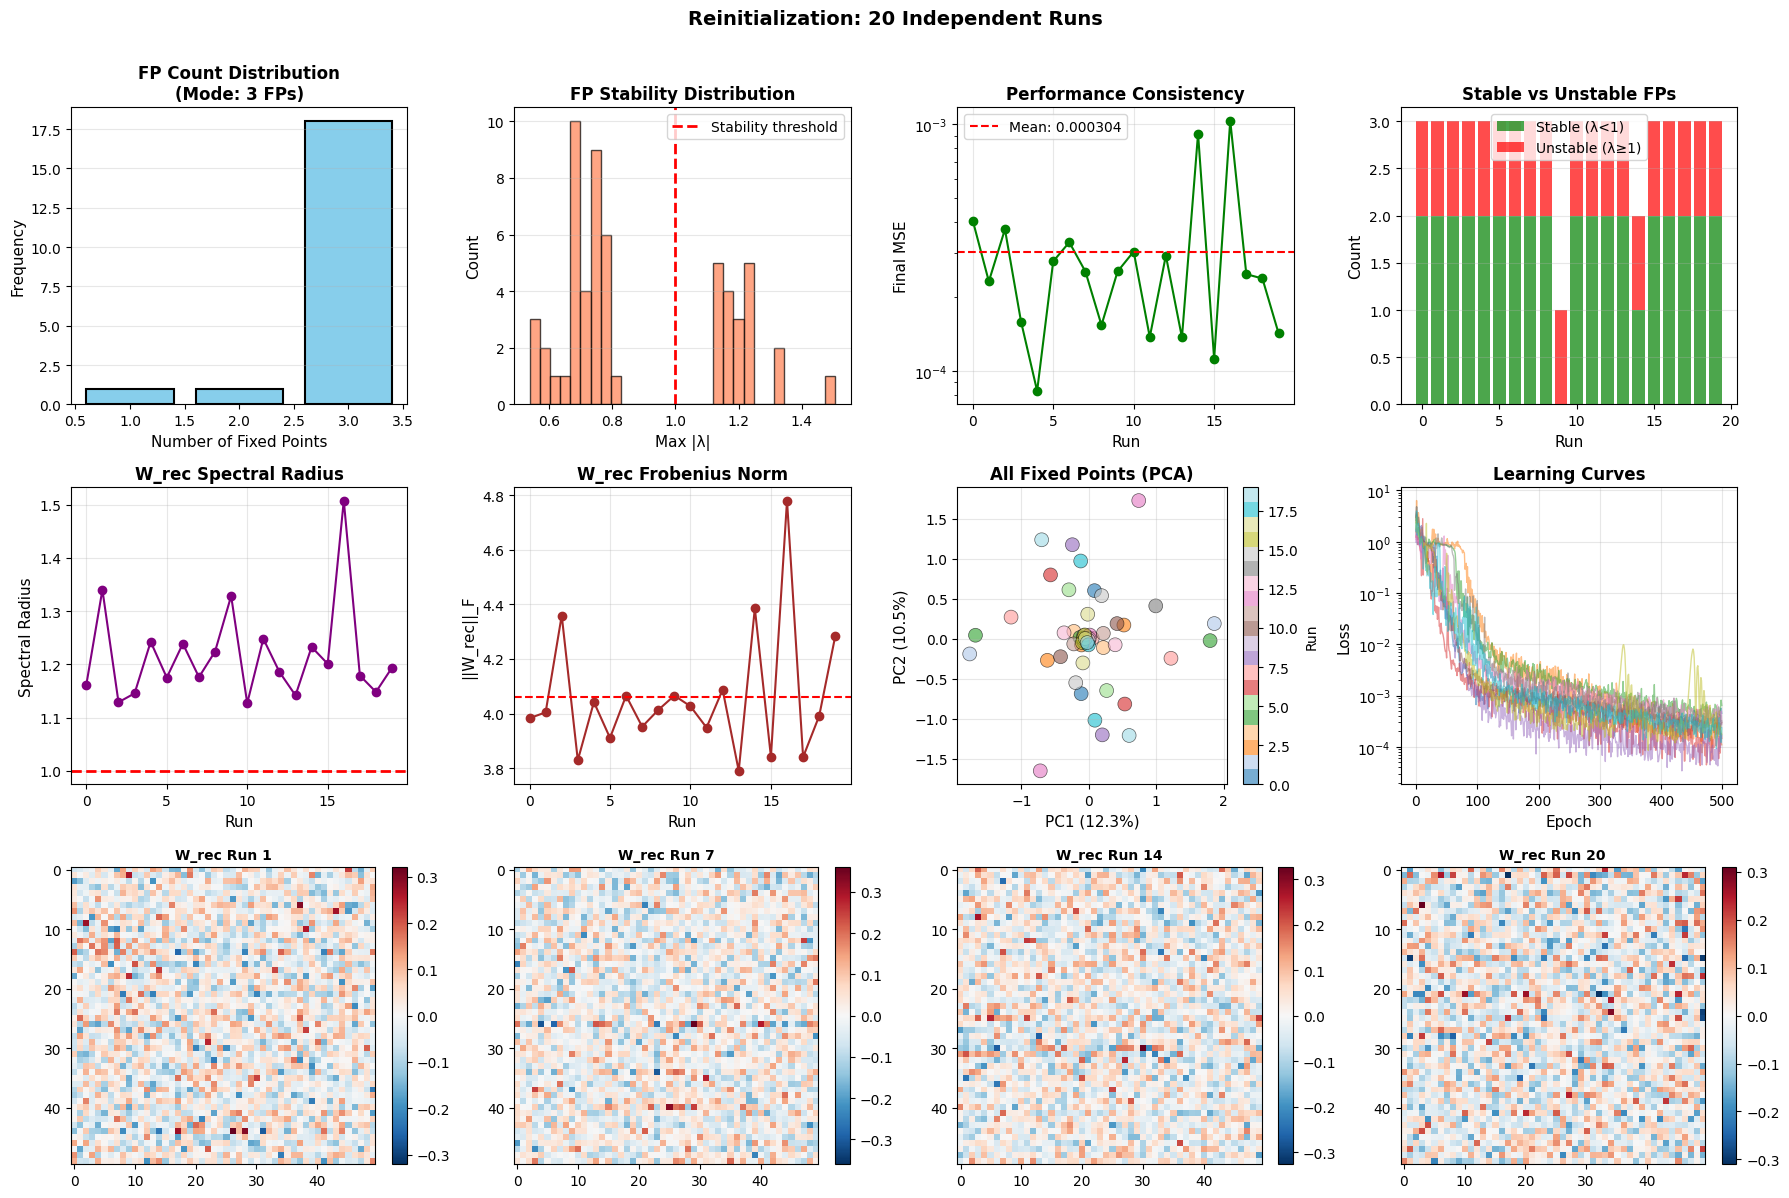


📊 SUMMARY STATISTICS
Runs: 20

Fixed Points:
  Mean: 2.85 ± 0.48
  Mode: 3
  Range: [1, 3]

Stable FPs per run:
  Mean: 1.85 ± 0.48

Performance:
  Mean MSE: 0.000304
  All converged: True

W_rec:
  Mean spectral radius: 1.216
  Mean norm: 4.06



In [ ]:
# ==============================================================================
# RUN THE EXPERIMENT
# ==============================================================================

# Run 20 training runs
results = reinitialization_experiment(n_runs=20, hidden_size=50, n_epochs=500)

# Analyze results
fig = analyze_reinitialization_results(results)

In [3]:
# ==============================================================================
# RESHUFFLING EXPERIMENT
# Test if the learned structure is coordinate-independent
# ==============================================================================

def reshuffle_network(model, permutation=None):
    """
    Permute the hidden units of a trained network.
    If permutation is None, use random permutation.
    
    Returns:
        shuffled_model: new model with permuted weights
        permutation: the permutation used
    """
    if permutation is None:
        permutation = torch.randperm(model.hidden_size)
    
    # Create new model
    shuffled_model = SimpleRNN(
        input_size=model.W_in.shape[1],
        hidden_size=model.hidden_size,
        output_size=model.W_out.shape[0]
    )
    
    # Permute recurrent weights (rows AND columns)
    W_rec_shuffled = model.W_rec[permutation][:, permutation]
    
    # Permute input weights (rows only)
    W_in_shuffled = model.W_in[permutation, :]
    
    # Permute output weights (columns only)
    W_out_shuffled = model.W_out[:, permutation]
    
    # Permute biases
    b_rec_shuffled = model.b_rec[permutation]
    
    # Set shuffled weights
    shuffled_model.W_rec.data = W_rec_shuffled
    shuffled_model.W_in.data = W_in_shuffled
    shuffled_model.W_out.data = W_out_shuffled
    shuffled_model.b_rec.data = b_rec_shuffled
    shuffled_model.b_out.data = model.b_out.clone()
    
    return shuffled_model, permutation


def test_reshuffling(model, task, n_shuffles=20):
    """
    Test if network structure survives permutation of hidden units
    
    Returns:
        results: dict with performance and fixed point data
    """
    print("\n" + "="*70)
    print("RESHUFFLING EXPERIMENT: Testing Coordinate Independence")
    print("="*70 + "\n")
    
    # Original network performance
    print("Testing original network...")
    inputs, targets = task.generate()
    inputs, targets = inputs.to(device), targets.to(device)
    
    with torch.no_grad():
        outputs_orig = model(inputs)
    mse_orig = nn.MSELoss()(outputs_orig, targets).item()
    
    # Find fixed points of original
    print("Finding fixed points of original network...")
    fps_orig, stabs_orig = find_fixed_points(model, input_val=0.0, n_inits=100)
    
    print(f"\nOriginal network:")
    print(f"  MSE: {mse_orig:.6f}")
    print(f"  Fixed points: {len(fps_orig)}")
    print(f"  Stable: {sum(1 for s in stabs_orig if s < 1)}")
    print(f"  Unstable: {sum(1 for s in stabs_orig if s >= 1)}\n")
    
    # Storage
    results = {
        'original': {
            'mse': mse_orig,
            'fps': fps_orig,
            'stabilities': stabs_orig
        },
        'shuffled': []
    }
    
    # Test multiple shuffles
    for shuffle_idx in range(n_shuffles):
        print(f"Shuffle {shuffle_idx+1}/{n_shuffles}...", end=" ")
        
        # Shuffle the network
        shuffled_model, perm = reshuffle_network(model)
        shuffled_model = shuffled_model.to(device)
        
        # Test performance
        with torch.no_grad():
            outputs_shuffled = shuffled_model(inputs)
        mse_shuffled = nn.MSELoss()(outputs_shuffled, targets).item()
        
        # Find fixed points
        fps_shuffled, stabs_shuffled = find_fixed_points(shuffled_model, input_val=0.0, n_inits=100)
        
        results['shuffled'].append({
            'mse': mse_shuffled,
            'fps': fps_shuffled,
            'stabilities': stabs_shuffled,
            'permutation': perm.cpu()
        })
        
        print(f"MSE: {mse_shuffled:.6f}, FPs: {len(fps_shuffled)}")
    
    print("\n" + "="*70)
    print("✅ Reshuffling complete!")
    print("="*70 + "\n")
    
    return results


def analyze_reshuffling_results(results):
    """Visualize reshuffling experiment results"""
    n_shuffles = len(results['shuffled'])
    
    fig = plt.figure(figsize=(16, 10))
    
    # 1. Performance comparison
    ax1 = plt.subplot(2, 4, 1)
    mse_orig = results['original']['mse']
    mse_shuffled = [r['mse'] for r in results['shuffled']]
    
    ax1.axhline(mse_orig, color='blue', linewidth=3, label='Original', linestyle='--')
    ax1.plot(mse_shuffled, 'o-', color='orange', markersize=6, label='Shuffled')
    ax1.set_xlabel('Shuffle #', fontsize=11)
    ax1.set_ylabel('MSE', fontsize=11)
    ax1.set_title('Performance: Original vs Shuffled', fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # 2. Fixed point count comparison
    ax2 = plt.subplot(2, 4, 2)
    n_fps_orig = len(results['original']['fps'])
    n_fps_shuffled = [len(r['fps']) for r in results['shuffled']]
    
    ax2.axhline(n_fps_orig, color='blue', linewidth=3, label='Original', linestyle='--')
    ax2.plot(n_fps_shuffled, 'o-', color='orange', markersize=6, label='Shuffled')
    ax2.set_xlabel('Shuffle #', fontsize=11)
    ax2.set_ylabel('# Fixed Points', fontsize=11)
    ax2.set_title('Fixed Point Count Preservation', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Stability preservation
    ax3 = plt.subplot(2, 4, 3)
    stable_orig = sum(1 for s in results['original']['stabilities'] if s < 1)
    stable_shuffled = [sum(1 for s in r['stabilities'] if s < 1) for r in results['shuffled']]
    
    ax3.axhline(stable_orig, color='green', linewidth=3, label='Original', linestyle='--')
    ax3.plot(stable_shuffled, 'o-', color='orange', markersize=6, label='Shuffled')
    ax3.set_xlabel('Shuffle #', fontsize=11)
    ax3.set_ylabel('# Stable FPs', fontsize=11)
    ax3.set_title('Stable FP Preservation', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. MSE distribution
    ax4 = plt.subplot(2, 4, 4)
    ax4.hist(mse_shuffled, bins=20, color='coral', alpha=0.7, edgecolor='black')
    ax4.axvline(mse_orig, color='blue', linewidth=3, linestyle='--', label='Original')
    ax4.set_xlabel('MSE', fontsize=11)
    ax4.set_ylabel('Count', fontsize=11)
    ax4.set_title('MSE Distribution', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    # 5. All fixed points in PCA space
    ax5 = plt.subplot(2, 2, 3)
    
    # Collect all fixed points (original + shuffled)
    all_fps = []
    labels = []
    
    # Original (blue)
    for fp in results['original']['fps']:
        all_fps.append(fp.cpu().squeeze().numpy())
        labels.append(0)  # 0 = original
    
    # Shuffled (various colors)
    for shuffle_idx, shuffle_result in enumerate(results['shuffled']):
        for fp in shuffle_result['fps']:
            all_fps.append(fp.cpu().squeeze().numpy())
            labels.append(shuffle_idx + 1)  # 1, 2, 3... = shuffled runs
    
    if len(all_fps) > 0:
        all_fps = np.array(all_fps)
        
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        fps_2d = pca.fit_transform(all_fps)
        
        # Separate original from shuffled
        orig_mask = np.array(labels) == 0
        shuffled_mask = ~orig_mask
        
        # Plot
        ax5.scatter(fps_2d[shuffled_mask, 0], fps_2d[shuffled_mask, 1],
                   c=np.array(labels)[shuffled_mask], cmap='tab20',
                   s=60, alpha=0.4, edgecolors='none', label='Shuffled')
        ax5.scatter(fps_2d[orig_mask, 0], fps_2d[orig_mask, 1],
                   c='blue', s=200, alpha=0.8, edgecolors='black',
                   linewidth=2, marker='*', label='Original', zorder=10)
        
        ax5.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
        ax5.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
        ax5.set_title('Fixed Points: Original vs Shuffled (PCA)', fontsize=12, fontweight='bold')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
    
    # 6. Summary statistics
    ax6 = plt.subplot(2, 2, 4)
    ax6.axis('off')
    
    # Calculate statistics
    mse_change_pct = [(s - mse_orig) / mse_orig * 100 for s in mse_shuffled]
    fp_preserved = sum(1 for n in n_fps_shuffled if n == n_fps_orig)
    stable_preserved = sum(1 for n in stable_shuffled if n == stable_orig)
    
    summary_text = f"""
    RESHUFFLING SUMMARY
    {'='*40}
    
    Original Network:
      MSE: {mse_orig:.6f}
      Fixed Points: {n_fps_orig}
      Stable FPs: {stable_orig}
    
    After {n_shuffles} Shuffles:
      Mean MSE: {np.mean(mse_shuffled):.6f}
      MSE Change: {np.mean(mse_change_pct):.2f}% ± {np.std(mse_change_pct):.2f}%
      
      FP Count Preserved: {fp_preserved}/{n_shuffles} ({fp_preserved/n_shuffles*100:.0f}%)
      Stable FP Preserved: {stable_preserved}/{n_shuffles} ({stable_preserved/n_shuffles*100:.0f}%)
      
    Conclusion:
      {'✅ Structure is COORDINATE-FREE!' if fp_preserved/n_shuffles > 0.8 else '⚠️ Structure may be coordinate-dependent'}
    """
    
    ax6.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.suptitle('Reshuffling Analysis: Testing Coordinate Independence', 
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    
    return fig




RESHUFFLING EXPERIMENT: Testing Coordinate Independence

Testing original network...
Finding fixed points of original network...

Original network:
  MSE: 0.000401
  Fixed points: 3
  Stable: 2
  Unstable: 1

Shuffle 1/20... MSE: 0.000401, FPs: 3
Shuffle 2/20... MSE: 0.000401, FPs: 3
Shuffle 3/20... MSE: 0.000401, FPs: 3
Shuffle 4/20... MSE: 0.000401, FPs: 3
Shuffle 5/20... MSE: 0.000401, FPs: 3
Shuffle 6/20... MSE: 0.000401, FPs: 3
Shuffle 7/20... MSE: 0.000401, FPs: 3
Shuffle 8/20... MSE: 0.000401, FPs: 3
Shuffle 9/20... MSE: 0.000401, FPs: 3
Shuffle 10/20... MSE: 0.000401, FPs: 3
Shuffle 11/20... MSE: 0.000401, FPs: 3
Shuffle 12/20... MSE: 0.000401, FPs: 3
Shuffle 13/20... MSE: 0.000401, FPs: 3
Shuffle 14/20... MSE: 0.000401, FPs: 3
Shuffle 15/20... MSE: 0.000401, FPs: 3
Shuffle 16/20... MSE: 0.000401, FPs: 3
Shuffle 17/20... MSE: 0.000401, FPs: 3
Shuffle 18/20... MSE: 0.000401, FPs: 3
Shuffle 19/20... MSE: 0.000401, FPs: 3
Shuffle 20/20... MSE: 0.000401, FPs: 3

✅ Reshuffling comp

C:\Users\Jasper\AppData\Local\Temp\ipykernel_27808\2922312444.py:252: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
C:\Users\Jasper\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


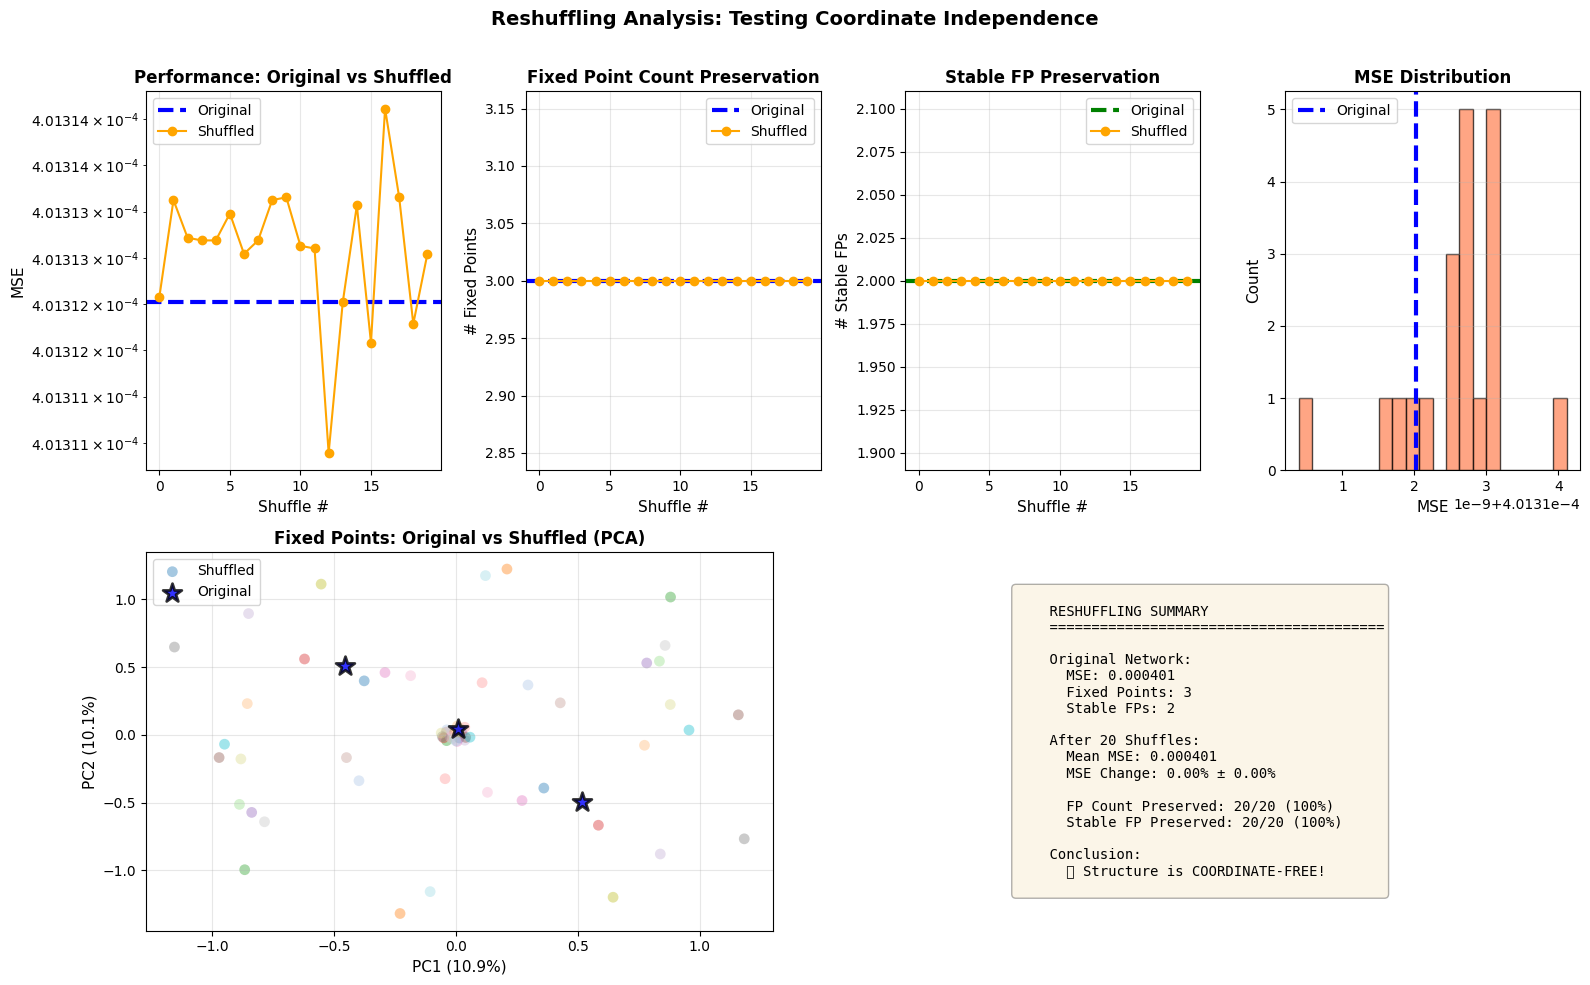

In [ ]:
# ==============================================================================
# RUN RESHUFFLING EXPERIMENT
# ==============================================================================

# Load one of your trained models from reinitialization
# Use the first model as example
model_state = results['models'][0]
model = SimpleRNN(input_size=1, hidden_size=50, output_size=1).to(device)
model.load_state_dict(model_state)

# Create task
task = SimpleFlipFlopTask(batch_size=100, seq_len=200)

# Run reshuffling experiment
shuffle_results = test_reshuffling(model, task, n_shuffles=20)

# Analyze
fig_shuffle = analyze_reshuffling_results(shuffle_results)

In [7]:
# ==============================================================================
# PHASE 1 COMPLETION: Architectural Robustness
# Test flip-flop across different network designs
# ==============================================================================

class ConfigurableRNN(nn.Module):
    """RNN with configurable activation function"""
    def __init__(self, input_size=1, hidden_size=50, output_size=1, 
                 activation='tanh', tau=1.0, dt=1.0):
        super(ConfigurableRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.tau = tau
        self.dt = dt
        self.alpha = dt / tau
        
        # Activation function
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'relu':
            self.activation = torch.relu
        elif activation == 'sigmoid':
            # Shifted sigmoid to match tanh range [-1, 1]
            self.activation = lambda x: 2 * torch.sigmoid(x) - 1
        else:
            raise ValueError(f"Unknown activation: {activation}")
        
        self.activation_name = activation
        
        # Weights
        self.W_rec = nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.5 / np.sqrt(hidden_size))
        self.W_in = nn.Parameter(torch.randn(hidden_size, input_size) * 1.0)
        self.W_out = nn.Parameter(torch.randn(output_size, hidden_size) * 1.0)
        self.b_rec = nn.Parameter(torch.zeros(hidden_size))
        self.b_out = nn.Parameter(torch.zeros(output_size))
        
    def forward(self, inputs, return_states=False):
        batch_size, seq_len, _ = inputs.shape
        device = inputs.device
        
        h = torch.zeros(batch_size, self.hidden_size, device=device)
        
        outputs = []
        states = [h] if return_states else None
        
        for t in range(seq_len):
            u = inputs[:, t, :]
            
            # RNN update with time constant
            activation = h @ self.W_rec.t() + u @ self.W_in.t() + self.b_rec
            h_new = self.activation(activation)
            h = (1 - self.alpha) * h + self.alpha * h_new
            
            o = h @ self.W_out.t() + self.b_out
            outputs.append(o)
            
            if return_states:
                states.append(h)
        
        outputs = torch.stack(outputs, dim=1)
        
        if return_states:
            states = torch.stack(states, dim=1)
            return outputs, states
        
        return outputs


def test_architecture_robustness(architectures, n_runs_per_arch=5, n_epochs=500):
    """
    Test flip-flop across different architectures
    
    Args:
        architectures: list of dicts with 'hidden_size', 'activation', 'tau'
        n_runs_per_arch: how many training runs per architecture
        n_epochs: training epochs
    """
    
    print("\n" + "="*70)
    print("ARCHITECTURAL ROBUSTNESS TEST")
    print("="*70 + "\n")
    
    all_results = {}
    
    for arch_idx, arch_config in enumerate(architectures):
        arch_name = f"{arch_config['activation']}_{arch_config['hidden_size']}units"
        if arch_config.get('tau', 1.0) != 1.0:
            arch_name += f"_tau{arch_config['tau']}"
        
        print(f"\n{'='*70}")
        print(f"Architecture {arch_idx+1}/{len(architectures)}: {arch_name}")
        print(f"{'='*70}\n")
        
        arch_results = {
            'config': arch_config,
            'runs': [],
            'final_mse': [],
            'n_fixed_points': [],
            'stable_fps': [],
            'converged': []
        }
        
        for run in range(n_runs_per_arch):
            seed = run * 123 + arch_idx * 456
            torch.manual_seed(seed)
            np.random.seed(seed)
            
            print(f"  Run {run+1}/{n_runs_per_arch}...", end=" ")
            
            # Create model
            model = ConfigurableRNN(
                input_size=1,
                hidden_size=arch_config['hidden_size'],
                output_size=1,
                activation=arch_config['activation'],
                tau=arch_config.get('tau', 1.0)
            ).to(device)
            
            # Create task
            task = SimpleFlipFlopTask(batch_size=32, seq_len=200)
            
            # Move data to GPU
            original_generate = task.generate
            def generate_gpu(flip_prob=0.03):
                inputs, targets = original_generate(flip_prob)
                return inputs.to(device), targets.to(device)
            task.generate = generate_gpu
            
            # Train
            try:
                losses = train_rnn(model, task, n_epochs=n_epochs, lr=0.01, verbose=False)
                
                # Evaluate
                task.batch_size = 100
                inputs, targets = task.generate()
                with torch.no_grad():
                    outputs = model(inputs)
                mse = nn.MSELoss()(outputs, targets).item()
                
                # Find fixed points (catch errors for ReLU)
                try:
                    fps, stabs = find_fixed_points(model, input_val=0.0, n_inits=50)
                    n_fps = len(fps)
                    stable = sum(1 for s in stabs if s < 1)
                except:
                    # Some activations may not have clean fixed points
                    fps, stabs = [], []
                    n_fps = 0
                    stable = 0
                
                converged = mse < 0.01
                
                arch_results['runs'].append({
                    'losses': losses,
                    'mse': mse,
                    'fps': fps,
                    'stabilities': stabs
                })
                arch_results['final_mse'].append(mse)
                arch_results['n_fixed_points'].append(n_fps)
                arch_results['stable_fps'].append(stable)
                arch_results['converged'].append(converged)
                
                status = "✓" if converged else "✗"
                print(f"{status} Loss: {losses[-1]:.6f}, MSE: {mse:.6f}, FPs: {n_fps} ({stable} stable)")
                
            except Exception as e:
                print(f"✗ Failed: {e}")
                arch_results['runs'].append(None)
                arch_results['final_mse'].append(np.nan)
                arch_results['n_fixed_points'].append(0)
                arch_results['stable_fps'].append(0)
                arch_results['converged'].append(False)
            
            # Clear GPU
            if device.type == 'cuda':
                torch.cuda.empty_cache()
        
        all_results[arch_name] = arch_results
        
        # Summary for this architecture
        converged_runs = sum(arch_results['converged'])
        if converged_runs > 0:
            avg_mse = np.nanmean([m for m in arch_results['final_mse'] if not np.isnan(m)])
            avg_fps = np.mean([n for n, c in zip(arch_results['n_fixed_points'], arch_results['converged']) if c])
            
            print(f"\n  Summary: {converged_runs}/{n_runs_per_arch} converged")
            print(f"    Avg MSE: {avg_mse:.6f}")
            print(f"    Avg FPs: {avg_fps:.1f}")
        else:
            print(f"\n  Summary: 0/{n_runs_per_arch} converged - architecture may not work well")
    
    print("\n" + "="*70)
    print("✅ Architectural robustness test complete!")
    print("="*70 + "\n")
    
    return all_results


def visualize_architectural_comparison(all_results):
    """Compare results across architectures"""
    
    arch_names = list(all_results.keys())
    n_archs = len(arch_names)
    
    fig = plt.figure(figsize=(16, 10))
    
    # 1. Performance comparison
    ax1 = plt.subplot(2, 3, 1)
    positions = []
    mse_data = []
    for i, name in enumerate(arch_names):
        mses = [m for m in all_results[name]['final_mse'] if not np.isnan(m)]
        if mses:
            positions.extend([i] * len(mses))
            mse_data.extend(mses)
    
    ax1.scatter(positions, mse_data, alpha=0.6, s=100)
    ax1.set_xticks(range(n_archs))
    ax1.set_xticklabels(arch_names, rotation=45, ha='right')
    ax1.set_ylabel('Final MSE', fontsize=11)
    ax1.set_title('Performance Across Architectures', fontsize=12, fontweight='bold')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.axhline(0.01, color='red', linestyle='--', alpha=0.5, label='Convergence threshold')
    ax1.legend()
    
    # 2. Fixed point count
    ax2 = plt.subplot(2, 3, 2)
    fp_means = []
    fp_stds = []
    for name in arch_names:
        fps = [n for n, c in zip(all_results[name]['n_fixed_points'], 
                                  all_results[name]['converged']) if c]
        fp_means.append(np.mean(fps) if fps else 0)
        fp_stds.append(np.std(fps) if fps else 0)
    
    ax2.bar(range(n_archs), fp_means, yerr=fp_stds, capsize=5, 
            color='skyblue', edgecolor='black', linewidth=1.5)
    ax2.set_xticks(range(n_archs))
    ax2.set_xticklabels(arch_names, rotation=45, ha='right')
    ax2.set_ylabel('# Fixed Points', fontsize=11)
    ax2.set_title('Fixed Point Count', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. Convergence rate
    ax3 = plt.subplot(2, 3, 3)
    convergence_rates = [sum(all_results[name]['converged']) / len(all_results[name]['converged']) 
                         for name in arch_names]
    bars = ax3.bar(range(n_archs), convergence_rates, 
                   color=['green' if r == 1.0 else 'orange' if r > 0.5 else 'red' 
                          for r in convergence_rates],
                   edgecolor='black', linewidth=1.5)
    ax3.set_xticks(range(n_archs))
    ax3.set_xticklabels(arch_names, rotation=45, ha='right')
    ax3.set_ylabel('Convergence Rate', fontsize=11)
    ax3.set_title('Training Success Rate', fontsize=12, fontweight='bold')
    ax3.set_ylim([0, 1.1])
    ax3.axhline(1.0, color='green', linestyle='--', alpha=0.5)
    ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Stable FP count
    ax4 = plt.subplot(2, 3, 4)
    stable_means = []
    stable_stds = []
    for name in arch_names:
        stables = [n for n, c in zip(all_results[name]['stable_fps'], 
                                     all_results[name]['converged']) if c]
        stable_means.append(np.mean(stables) if stables else 0)
        stable_stds.append(np.std(stables) if stables else 0)
    
    ax4.bar(range(n_archs), stable_means, yerr=stable_stds, capsize=5,
            color='lightgreen', edgecolor='black', linewidth=1.5)
    ax4.set_xticks(range(n_archs))
    ax4.set_xticklabels(arch_names, rotation=45, ha='right')
    ax4.set_ylabel('# Stable FPs', fontsize=11)
    ax4.set_title('Stable Fixed Points', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # 5. Learning curves comparison
    ax5 = plt.subplot(2, 3, 5)
    colors = plt.cm.tab10(np.linspace(0, 1, n_archs))
    for i, name in enumerate(arch_names):
        runs = all_results[name]['runs']
        for run in runs:
            if run is not None and 'losses' in run:
                ax5.plot(run['losses'], alpha=0.3, color=colors[i], linewidth=1)
        # Plot mean
        valid_losses = [run['losses'] for run in runs if run is not None and 'losses' in run]
        if valid_losses:
            mean_losses = np.mean(valid_losses, axis=0)
            ax5.plot(mean_losses, color=colors[i], linewidth=2, label=name)
    
    ax5.set_xlabel('Epoch', fontsize=11)
    ax5.set_ylabel('Loss', fontsize=11)
    ax5.set_title('Learning Curves', fontsize=12, fontweight='bold')
    ax5.set_yscale('log')
    ax5.legend(fontsize=8)
    ax5.grid(True, alpha=0.3)
    
    # 6. Summary table
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    summary_text = "ARCHITECTURE COMPARISON\n" + "="*40 + "\n\n"
    for name in arch_names:
        converged = sum(all_results[name]['converged'])
        total = len(all_results[name]['converged'])
        avg_fps = np.mean([n for n, c in zip(all_results[name]['n_fixed_points'], 
                                              all_results[name]['converged']) if c]) if converged > 0 else 0
        
        summary_text += f"{name}:\n"
        summary_text += f"  Converged: {converged}/{total}\n"
        summary_text += f"  Avg FPs: {avg_fps:.1f}\n\n"
    
    ax6.text(0.1, 0.9, summary_text, fontsize=9, family='monospace',
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.suptitle('Phase 1: Architectural Robustness Analysis', 
                 fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    
    return fig




ARCHITECTURAL ROBUSTNESS TEST


Architecture 1/4: tanh_50units

  Run 1/2... ✓ Loss: 0.000452, MSE: 0.000407, FPs: 3 (2 stable)
  Run 2/2... ✓ Loss: 0.002321, MSE: 0.001305, FPs: 3 (2 stable)

  Summary: 2/2 converged
    Avg MSE: 0.000856
    Avg FPs: 3.0

Architecture 2/4: sigmoid_50units

  Run 1/2... ✓ Loss: 0.000292, MSE: 0.000391, FPs: 1 (0 stable)
  Run 2/2... ✓ Loss: 0.000637, MSE: 0.000538, FPs: 1 (0 stable)

  Summary: 2/2 converged
    Avg MSE: 0.000465
    Avg FPs: 1.0

Architecture 3/4: tanh_25units

  Run 1/2... ✓ Loss: 0.000087, MSE: 0.000128, FPs: 3 (2 stable)
  Run 2/2... ✓ Loss: 0.000290, MSE: 0.000122, FPs: 3 (2 stable)

  Summary: 2/2 converged
    Avg MSE: 0.000125
    Avg FPs: 3.0

Architecture 4/4: relu_50units

  Run 1/2... ✓ Loss: 0.006288, MSE: 0.007162, FPs: 3 (0 stable)
  Run 2/2... ✓ Loss: 0.000029, MSE: 0.000020, FPs: 1 (0 stable)

  Summary: 2/2 converged
    Avg MSE: 0.003591
    Avg FPs: 2.0

✅ Architectural robustness test complete!



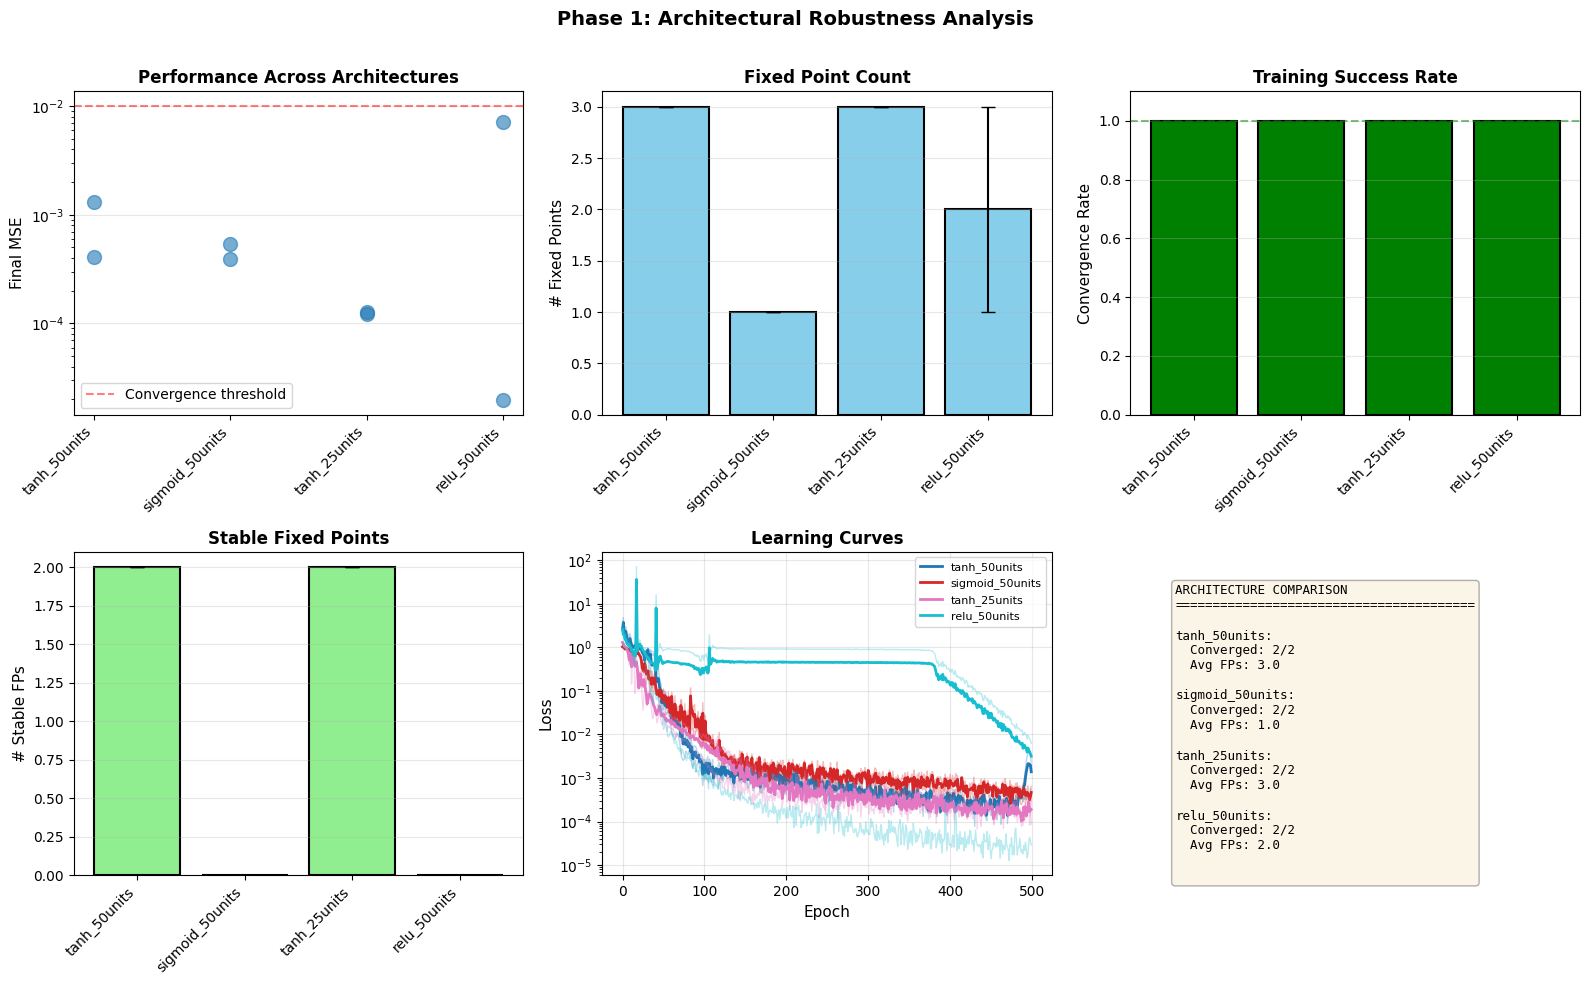

💾 Architectural results saved!


In [9]:
# ==============================================================================
# RUN ARCHITECTURAL COMPARISON
# ==============================================================================

# Define architectures to test
architectures = [
    {'hidden_size': 50, 'activation': 'tanh'},      # ✓ Works great
    {'hidden_size': 50, 'activation': 'sigmoid'},   # Should work well
    {'hidden_size': 25, 'activation': 'tanh'},      # ✓ Works great
    {'hidden_size': 50, 'activation': 'relu'},    # ✗ Skip this
]

# Optional: add more
# {'hidden_size': 100, 'activation': 'tanh'},     # Larger network
# {'hidden_size': 50, 'activation': 'sigmoid'},   # Another activation
# {'hidden_size': 50, 'activation': 'tanh', 'tau': 5.0},  # Slower dynamics

# Run comparison (5 runs per architecture to save time)
arch_results = test_architecture_robustness(
    architectures, 
    n_runs_per_arch=2,  # Keep it quick
    n_epochs=500
)

# Visualize
fig_arch = visualize_architectural_comparison(arch_results)

# Save results
with open('architectural_robustness_results.pkl', 'wb') as f:
    pickle.dump(arch_results, f)

print("💾 Architectural results saved!")